In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
figformat='png'

In [3]:
mag_sun = -27.1 # apparent r band magnitude of the sun. this sets the band for the magnitude limit.
# see http://www.ucolick.org/~cnaw/sun.html for apparent magnitudes in other bands.
km_per_au = 1.496e8

# UNITS:
# diameter is in kilometers
# distances from the sun / earth are in AU
# angles are in radians

# make a plot of object diameter vs semimajor axis (log/log) for various albedos and add some known comparisons
def setPlanets():
    # set up data on 'known' objects
    planet = {}
    planetlist = ('Earth', 'Mars', 'Jupiter', 'Saturn', 'Uranus', 'Neptune', 'Pluto', 'Sedna', 'Eris', 'Ceres')
    for obj in planetlist:
        planet[obj] = {}
    planet['Earth']['a'] = 1.000
    planet['Earth']['e'] = 0.0167
    planet['Earth']['i'] = 1.578
    planet['Earth']['size'] = 12742
    planet['Mars']['a'] = 1.523 
    planet['Mars']['e'] = 0.093
    planet['Mars']['i'] = 1.850
    planet['Mars']['size'] = 6792
    planet['Jupiter']['a'] = 5.204
    planet['Jupiter']['e'] = 0.0487
    planet['Jupiter']['i'] = 1.305
    planet['Jupiter']['size'] = 142984
    planet['Saturn']['a'] = 9.582
    planet['Saturn']['e'] = 0.0557
    planet['Saturn']['i'] = 2.485
    planet['Saturn']['size'] = 120536
    planet['Uranus']['a'] = 19.22
    planet['Uranus']['e'] = 0.044 
    planet['Uranus']['i'] = 0.772
    planet['Uranus']['size'] = 51118
    planet['Neptune']['a'] = 30.103 
    planet['Neptune']['e'] = 0.0112
    planet['Neptune']['i'] = 1.768
    planet['Neptune']['size'] = 49528
    planet['Pluto']['a'] = 39.481
    planet['Pluto']['e'] = 0.248
    planet['Pluto']['i'] = 17.14
    planet['Pluto']['size'] = 2306
    planet['Sedna']['a'] = 90
    planet['Sedna']['size'] = 1600
    planet['Eris']['a'] = 97
    planet['Eris']['size'] = 2400
    planet['Ceres']['a'] = 2.8
    planet['Ceres']['size'] = 950
    planetlist = ('Mars', 'Jupiter', 'Saturn', 'Uranus', 'Neptune', 'Pluto', 'Sedna', 'Eris', 'Ceres')
    return planet, planetlist

In [4]:
def calc_sundist(earth_dist, solarelongation):
    # given the solar elongation (single value, in RADIANS) and the distance from Earth to the object,
    # calculate and return the distance to the sun for the same object
    # uses the law of cosines
    sun_dist = np.sqrt(earth_dist**2 + 1 - 2*earth_dist*np.cos(solarelongation))
    return sun_dist

def calc_earthdist(sun_dist, solarelongation):
    # given the solar elongation (single value, radians) and the distance from the Sun to the object,
    # return the distance between Earth and the object
    phaseangle = calc_phaseangle(solarelongation, sun_dist)
    sangle = np.pi - solarelongation - phaseangle
    earth_dist = np.sqrt(1 + sun_dist**2 - 2*sun_dist*np.cos(sangle))
    earth_dist = np.where(np.isnan(earth_dist), 0, earth_dist)
    return earth_dist

def calc_phaseangle(solarelongation, sun_dist):
    # given the solar elongation (in RADIANS) and the distance from Sun to object
    # calculate and return the phase angle for the object (could be array)
    # using law of sines sin(angle)/opposite side = sin(angle2) / opposite side 2
    phaseangle = np.arcsin(np.sin(solarelongation) / sun_dist)
    return phaseangle

def calc_solarelongation(phaseangle, sun_dist):
    # given the phaseangle (in RADIANS) and the distance from the Sun to the object,
    # return the solar elongation for the object(s)
    solarelongation = np.arcsin(np.sin(phaseangle)*sun_dist)
    return solarelongation

def calc_phasefunction(phaseangle, gval=0.15):
    # given phase angle (0-180 IN RADIANS), compute how the brightness of the object varies
    # albedo*phase = how much sunlight is reflected
    phione = 10**(-3.33 * np.power(np.tan(phaseangle/2), 0.63))
    phitwo = 10**(-1.87 * np.power(np.tan(phaseangle/2), 1.22))
    phaseval = (1-gval)*phione + gval*phitwo
    return phaseval

def calc_Hmag(obsmag, earth_dist, sun_dist, solarelongation, gval=0.15):
    # H magnitude is 'absolute' magnitude, = mag object would have at 1 AU and 0 phase angle
    # H = m - 2.5 log(D**2 d**2 / phasefunc)
    phaseangle = calc_phaseangle(solarelongation, sun_dist)
    phasefunc = calc_phasefunction(phaseangle, gval)
    Hval = obsmag - 2.5 * np.log10(sun_dist**2 * earth_dist**2 / phasefunc)
    return Hval

def calc_diam(Hval, albedo):
    # calculate diameter of an object given the H magnitude and albedo
    # H = -2.5 log(Sunflux * albedo * radius**2 / radius(sphere)**2)
    # so, diam = sqrt(2/pi*10^[(H-Msun+2.5log(albedo))/2.5])
    tmpval = mag_sun - Hval - 2.5*np.log10(albedo)
    diam = np.sqrt(10**(tmpval/2.5)) * 2.0
    # convert units of diam from AU to km
    diam = diam * km_per_au
    return diam

def calc_Hmagfromdiam(diam, albedo):
    # calculate the H magnitude from an albedo ... this is only here for axis matching
    Hval = mag_sun - 2.5*np.log10(albedo*2.0*np.pi*(diam/2.0/km_per_au)**2)
    return Hval

In [5]:
# set xticks to be numbers not exponents
def log_10_product(x, pos):
    """The two args are the value and tick position.
    Label ticks with the product of the exponentiation"""
    return '%.1f' % (x)
formatter = plt.FuncFormatter(log_10_product)

In [6]:
def plot_diamvsHELIO(maglim=24.5, solarelongation=180, savefig=None):
    se = np.radians(solarelongation)
    colors = ('g', 'b', 'r', 'm')
    albedos = [0.05, 0.20, 0.50]
    albedos = np.array(albedos)
    # distances in AU
    earth_dist = np.arange(0.00, 5, 0.01)
    earth_dist = np.concatenate((earth_dist, np.arange(5, 5000, 0.2)))
    sun_dist = calc_sundist(earth_dist, se)
    Hmags = calc_Hmag(maglim, earth_dist, sun_dist, se)
    
    fig1 = plt.figure(figsize=(9, 7))
    ax1 = fig1.add_subplot(111)
    i = 0
    for albedo in albedos:
        diameter = calc_diam(Hmags, albedo)
        ax1.loglog(sun_dist, diameter, colors[i]+'-', linewidth=2, label="%d%s albedo" %(albedo*100, "%"))
        i = i + 1
    # add shading for 'unobservable region'
    albedo = 1
    diameter = calc_diam(Hmags, albedo)
    ax1.fill_between(x=sun_dist, y1=1e-10, y2=diameter, color='k', alpha=0.2, edgecolor=None)
    plt.figtext(0.75, 0.72, "Beyond limit", rotation=40, weight='semibold', style='oblique')

    # add the 'belts'
    asteroidinner = 2.5
    asteroidouter = 5
    ax1.axvspan(asteroidinner, asteroidouter, alpha=0.5, color='y', edgecolor=None)
    kbinner = 30
    kbouter = 50
    ax1.axvspan(kbinner, kbouter, alpha=0.5, color='y', edgecolor=None)
    ax1.annotate('Main Belt', (3.5, 0.025), rotation='vertical')
    ax1.annotate('Kuiper Belt', (35, 0.04), rotation='vertical')
    
    # add the 'known object comparisons'
    # scale their geocentric distances as if they were in circular orbits @ sun_dist = a
    planet, planetlist = setPlanets()
    sign = -1
    for planetname in planetlist:
        geo_dist = calc_earthdist(planet[planetname]['a'], se) 
        ax1.loglog(planet[planetname]['a'], planet[planetname]['size'], 
                   marker='o', color='r', markeredgecolor='k')
        ax1.annotate(planetname, ((planet[planetname]['a'])*1.15, planet[planetname]['size']*(.9+sign*.2)))
        sign = sign * -1
    # add the PHA limit
    ax1.axhline(.140, xmin=0, xmax=0.37, color='k', linestyle='--', linewidth=3)
    plt.annotate("PHA 140m", (4.8, 0.11), weight='demibold')
    
    ax1.set_xlabel("Heliocentric Distance (AU)",  fontsize='x-large')
    ax1.set_ylabel("Object Diameter (km)",  fontsize='x-large')
    plt.title("LSST detection limits, single visit (r=%.1f)" %(maglim),  fontsize='x-large')
    ax1.legend(loc='lower right', numpoints=1, fancybox=True, fontsize='smaller')
    plt.ylim(0.001, 500000)
    plt.xlim(0.1, 3000)
    # add twin axes for H
    # twin axis for H mag on right
    ax2 = ax1.twinx()
    y1, y2 = ax1.get_ylim()
    h1 = calc_Hmagfromdiam(y1, 1)
    h2 = calc_Hmagfromdiam(y2, 1)
    ax2.set_ylim(h1, h2)
    ax2.set_ylabel("H magnitude", fontsize='x-large')
    ax2.xaxis.set_major_formatter(formatter)
    
    # add a little inset showing which direction we're looking
    # this is another inset axes over the main axes
    b = plt.axes([0.6, 0.28, .2, .2], frameon=False)
    ptlen = 5.0
    xpt = ptlen*np.cos(np.pi-se)
    ypt = ptlen*np.sin(np.pi-se)
    xpoints = [0.0, 1.0, xpt]
    ypoints = [0.0, 0.0, ypt] 
    b.annotate("Sun", (-.18,-1.4), rotation=-45, size='small')
    b.annotate("Earth", (.73, -1.4), rotation=-45, size='small')
    b.plot(xpoints, ypoints, 'k-', linewidth=1.5)
    b.plot(xpoints, ypoints, 'ro')
    title = plt.title('Solar elongation %.1f' %(solarelongation))
    plt.setp(title, horizontalalignment='center', fontsize='small')
    plt.setp(b, xlim=(-0.2, 3.1), ylim=(-3,2), xticks=[], yticks=[])

    ax1.grid(True, alpha=0.4)    
    if savefig!=None:
        plt.savefig(savefig+"."+figformat, format=figformat)
        plt.close()
    return

In [7]:
def plot_diamvsGEO(maglim=24.5, solarelongation=180, savefig=None):
    se = np.radians(solarelongation)
    colors = ('g', 'b', 'r', 'm')
    albedos = [0.05, 0.20, 0.50]
    albedos = np.array(albedos)
    # distances in AU
    earth_dist = np.arange(0.0, 5, 0.01)
    earth_dist = np.concatenate((earth_dist, np.arange(5, 10000, 0.2)))
    sun_dist = calc_sundist(earth_dist, se)    
    Hmags = calc_Hmag(maglim, earth_dist, sun_dist, se)
    
    fig1 = plt.figure(figsize=(9,7))
    ax1 = fig1.add_subplot(111)
    i = 0
    for albedo in albedos:
        diameter = calc_diam(Hmags, albedo)
        ax1.loglog(earth_dist, diameter, colors[i]+'-', linewidth=2, label="%d%s albedo" %(albedo*100, "%"))
        i = i + 1
    # add shading for 'unobservable region'
    albedo = 1
    diameter = calc_diam(Hmags, albedo)
    ax1.fill_between(x=earth_dist, y1=1e-5, y2=diameter, color='k', alpha=0.2, edgecolor=None)
    plt.figtext(0.75, 0.72, "Beyond limit", rotation=40, weight='semibold', style='oblique')

    # add the 'belts'
    asteroidinner = 2.5
    asteroidinner_earthd = calc_earthdist(asteroidinner, se)
    asteroidouter = 5
    asteroidouter_earthd = calc_earthdist(asteroidouter, se)
    ax1.axvspan(asteroidinner_earthd, asteroidouter_earthd, alpha=0.5, color='y', edgecolor=None)
    kbinner = 30
    kbinner_earthd = calc_earthdist(kbinner, se)
    kbouter = 50
    kbouter_earthd = calc_earthdist(kbouter, se)
    ax1.axvspan(kbinner_earthd, kbouter_earthd, alpha=0.5, color='y', edgecolor=None)
    ax1.annotate('Main Belt', (3, 0.025), rotation='vertical')
    ax1.annotate('Kuiper Belt', (35, 0.04), rotation='vertical')

    # add the 'known object comparisons'
    # scale their geocentric distances as if they were in circular orbits @ sun_dist = a
    planet, planetlist = setPlanets()
    sign = -1
    for planetname in planetlist:
        geo_dist = calc_earthdist(planet[planetname]['a'], se) 
        plt.loglog(geo_dist, planet[planetname]['size'], marker='o', color='r', markeredgecolor='k')
        plt.annotate(planetname, ((geo_dist)*1.15, planet[planetname]['size']*(.9+sign*.2)))
        sign = sign * -1
        
    # add the PHA limit
    ax1.axhline(.140, xmin=0, xmax=0.37, color='k', linestyle='--', linewidth=3)
    plt.annotate("PHA 140m", (4.8, 0.11), weight='demibold')
    
    ax1.set_xlabel("Geocentric Distance (AU)",  fontsize='x-large')
    ax1.set_ylabel("Object Diameter (km)",  fontsize='x-large')
    plt.title("LSST detection limits, single visit (r=%.1f)" %(maglim),  fontsize='x-large')
    ax1.legend(loc='lower right', numpoints=1, fancybox=True, fontsize='small')
    plt.xlim(0.05, 3000)
    ax1.xaxis.set_major_formatter(formatter)
    plt.ylim(0.001, 500000)
    # add twin axes for H and geo distance
    # twin axis for H mag
    ax2 = ax1.twinx()
    y1, y2 = ax1.get_ylim()
    h1 = calc_Hmagfromdiam(y1, 1)
    h2 = calc_Hmagfromdiam(y2, 1)
    ax2.set_ylim(h1, h2)
    ax2.set_ylabel("H magnitude", fontsize='x-large')
    ax2.xaxis.set_major_formatter(formatter)
    # add a little inset showing which direction we're looking
    # this is another inset axes over the main axes
    b = plt.axes([0.63, 0.28, .2, .2], frameon=False)
    ptlen = 5.0
    xpt = ptlen*np.cos(np.pi-se)
    ypt = ptlen*np.sin(np.pi-se)
    xpoints = [0.0, 1.0, xpt]
    ypoints = [0.0, 0.0, ypt] 
    b.annotate("Sun", (-.18,-1.4), rotation=-45, size='small')
    b.annotate("Earth", (.73, -1.4), rotation=-45, size='small')
    b.plot(xpoints, ypoints, 'k-', linewidth=1.5)
    b.plot(xpoints, ypoints, 'ro')
    title = plt.title('Solar elongation %.1f' %(solarelongation))
    plt.setp(title, horizontalalignment='center', fontsize='small')
    plt.setp(b, xlim=(-0.2, 3.1), ylim=(-3,2), xticks=[], yticks=[])
    ax1.grid(True)
    if savefig is not None:
        plt.savefig(savefig+"."+figformat, format=figformat)
        plt.close()
    return

In [8]:
def plot_xypoints(sun_dist, solarelongation):
    plt.figure()
    ax = plt.axes(frameon=True)
    plt.axis('equal')
    # draw circles for Earth's orbit and distance of objects
    theta = np.arange(0, np.pi*.58, 0.01)
    x, y = 1*np.cos(theta), 1*np.sin(theta)
    plt.plot(x, y, 'k:')
    x, y = sun_dist*np.cos(theta), sun_dist*np.sin(theta)
    plt.plot(x, y, 'k:')
    for se in solarelongation:
        earth_dist = calc_earthdist(sun_dist, se)
        # earthdist**2 = H**2 + 1**2 - 2*H*cos(a)
        a = np.arccos((1 - earth_dist**2 + sun_dist**2)/(2*sun_dist))
        x, y = (sun_dist * np.cos(a)), (sun_dist * np.sin(a))
        # add points for objects
        plt.plot(x, y, 'ko')
        # add line & label for Earth distances
        plt.plot((1, x), (0, y), 'r-')
        xl, yl = (sun_dist*7.0/8.0*np.cos(a)), (sun_dist*4.0/5.0*np.sin(a))
        plt.annotate('Geo Dist\n %.1f AU' %(earth_dist), (xl+0.2, yl), color='r')
        # add line & label for sun distances
        plt.plot((0, x), (0, y), 'b-')
        xl, yl = (sun_dist/3.0*2.1 * np.cos(a)), (sun_dist/3.0*2.0 * np.sin(a))
        plt.annotate('Helio Dist\n %.1f AU' %(sun_dist),(xl-0.44, yl), color='b')
    # add points for Sun and Earth
    plt.plot(0, 0, 'bo')
    plt.annotate('Sun', (-.15,-0.15), size='large')
    plt.plot(1, 0, 'ro')
    plt.annotate('Earth', (1, -0.15), size='large')
    plt.plot((0, 1), (0, 0), 'k--')
    plt.xlim(-0.25, 2.25)
    plt.ylim(-0.25, 2.25)
    # add 'solar elongation' marker
    theta = np.arange(0, np.pi/3, 0.01)
    x, y = 1-.3*np.cos(theta), .3*np.sin(theta)
    plt.plot(x, y, color='k', linestyle='-', linewidth=2)
    plt.annotate('Solar Elongation Angle', (0.75, 0.15), xytext=(-0.5, 0.45),
                   arrowprops=(dict(arrowstyle='->', shrinkA=10, shrinkB=5,
                                    connectionstyle="angle3,angleA=-45,angleB=0")),
                   weight='bold')
    plt.setp(ax, xticks=[], yticks=[])
    return

/Users/lynnej/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log10


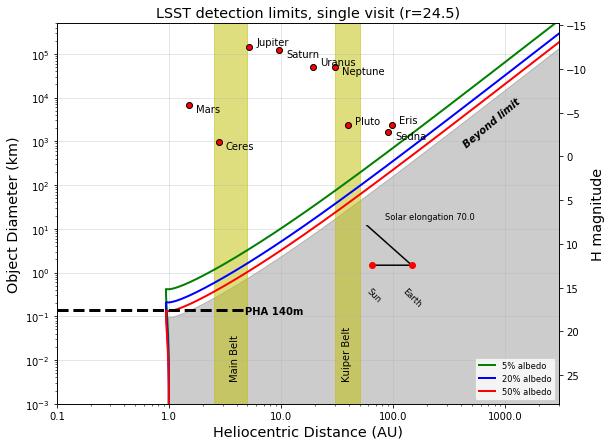

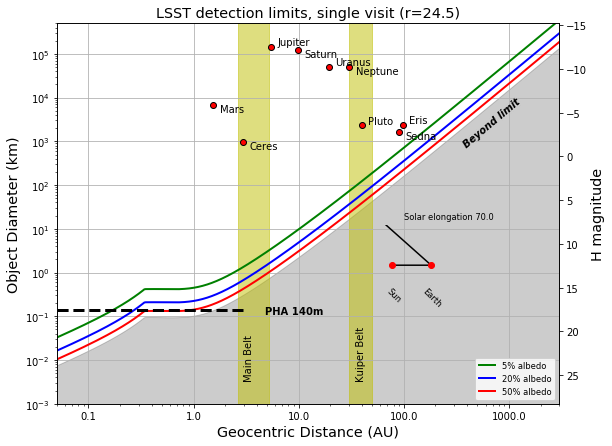

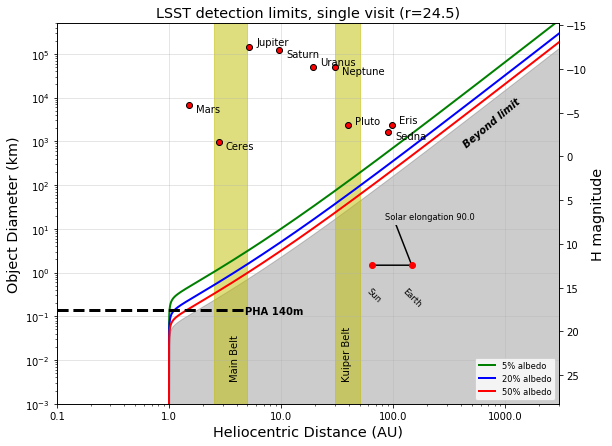

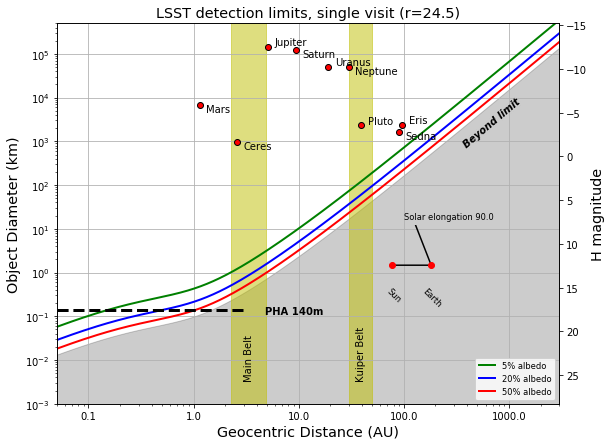

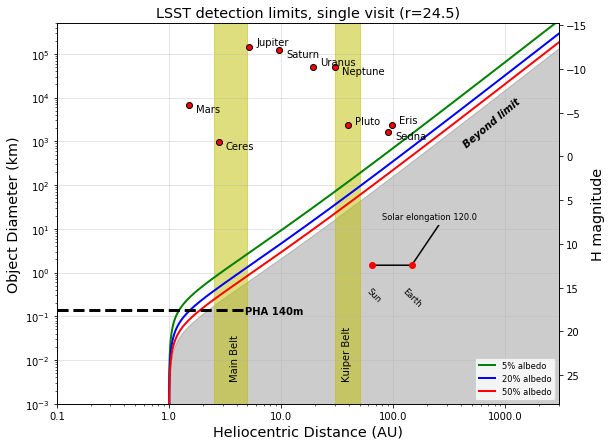

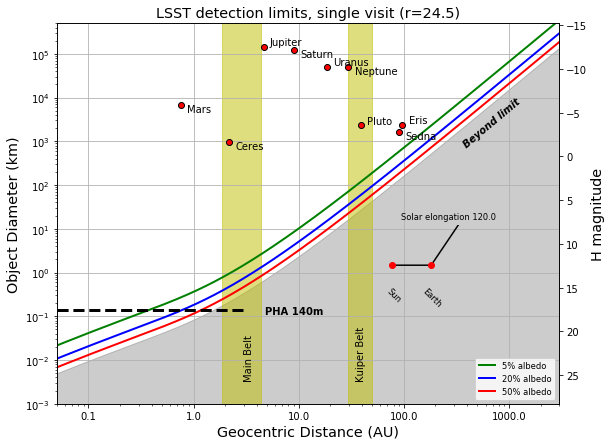

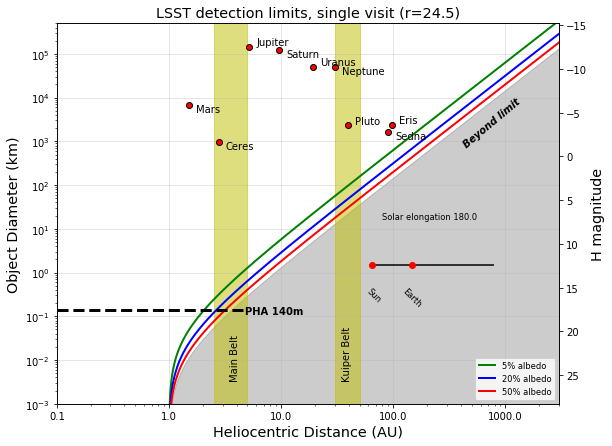

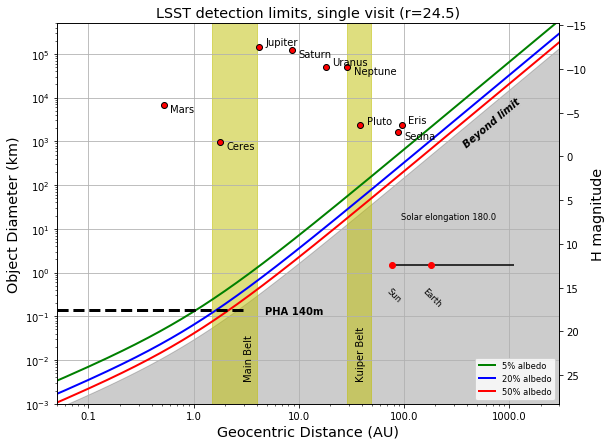

In [9]:
solarelonOnly = False
deg2rad = np.pi/180.0
solarelongation = np.array([70, 90, 120, 180])

if solarelonOnly:
    # make solar elongation example
    solarelongation = np.radians(np.array([170, 70]))
    earth_dist = np.array([2,])
    plot_xypoints(earth_dist, solarelongation)
    #plt.savefig("solarelongation.png", format='png')
else:
    # make distance/size movie images
    i = 0
    for se in solarelongation:
        figname = "_tmp%03d" %(i)
        i = i + 1
        plot_diamvsHELIO(24.5, se, savefig=None)#="HELIO"+figname)
        plot_diamvsGEO(24.5, se, savefig=None)#"GEO"+figname)